In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
# from observability.mlflow_integration import log_experiment

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import sum_log_return_loss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
retriever = AlpacaMarketsRetriever(download_from_gdrive=False)

retrieval_result = retriever.bars_with_quotes(
    symbol_or_symbols=config.data_config.symbol_or_symbols, 
    start=config.data_config.start, 
    end=config.data_config.end)

In [3]:
dataset_creator = DatasetCreator(
    features=config.data_config.features,
    target=config.data_config.target,
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    train_set_last_date=config.data_config.train_set_last_date, 
    in_seq_len=config.data_config.in_seq_len,
    multi_asset_prediction=config.data_config.multi_asset_prediction,
)

X_train, y_train, next_return_train, spread_train, X_test, y_test, next_return_test, spread_test = dataset_creator.create_dataset_numpy(retrieval_result)
X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape

2025-08-01 14:16:53,644 - INFO - Processing AAPL …
2025-08-01 14:16:54,031 - INFO - Imputing 496 NaN rows out of 97359 with forward fill..
2025-08-01 14:16:54,390 - INFO - Imputing 39 NaN rows with 0.5 sentinel value
2025-08-01 14:16:54,423 - INFO - Processing AMD …
2025-08-01 14:16:54,800 - INFO - Imputing 214 NaN rows out of 97359 with forward fill..
2025-08-01 14:16:55,142 - INFO - Imputing 39 NaN rows with 0.5 sentinel value
2025-08-01 14:16:55,162 - INFO - Processing BABA …
2025-08-01 14:16:55,495 - INFO - Imputing 874 NaN rows out of 97359 with forward fill..
2025-08-01 14:16:55,830 - INFO - Imputing 39 NaN rows with 0.5 sentinel value
2025-08-01 14:16:55,849 - INFO - Processing BITU …
2025-08-01 14:16:56,154 - INFO - Imputing 6493 NaN rows out of 97359 with forward fill..
2025-08-01 14:16:56,481 - INFO - Imputing 39 NaN rows with 0.5 sentinel value
2025-08-01 14:16:56,500 - INFO - Processing CSCO …
2025-08-01 14:16:56,797 - INFO - Imputing 3929 NaN rows out of 97359 with forward

((79909, 50, 120, 15),
 (79909, 50),
 (79909, 50),
 (79909, 50),
 (7251, 50, 120, 15),
 (7251, 50),
 (7251, 50),
 (7251, 50))

In [4]:
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, trajectory_length=16).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, trajectory_length=16).as_dataloader(
    batch_size=8, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)

In [5]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=0., spread_multiplier=0.33),
)

In [6]:
signal_predictor = config.model_config.model
signal_predictor.load_state_dict(torch.load('../modeling/checkpoints/best_model.pth'))
signal_predictor

C:\Users\ikurnosau\AppData\Local\Temp\ipykernel_1776\506540046.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  signal_predictor.load_state_dict(torch.load('../modeling/c

TemporalSpatial(
  (asset_embed): Embedding(50, 32)
  (asset_proj): Linear(in_features=32, out_features=512, bias=False)
  (lstm): LSTM(15, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (spatial_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
actor = RlActor(
    signal_predictor, 
    n_assets=len(config.data_config.symbol_or_symbols),
    hidden_dim=128,
    train_signal_predictor=False
).to(device)

signal_predictor_actor = SignalPredictorActor(
    signal_predictor, 
    trade_asset_count=5,
    train_signal_predictor=False
).to(device)

xsmom_actor = XSMomActor(
    look_back_window=20, 
    trade_asset_count=5
).to(device)

tsmom_actor = TSMomActor(
    look_back_window=20, 
)

blsw_actor = BLSWActor(
    look_back_window=20, 
    trade_asset_count=5
)

In [ ]:
rl_agent = RlAgent(
    actor, 
    env,
    single_action_per_trajectory=False
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=sum_log_return_loss,
    num_epochs=10,
    device=device
)

In [18]:
policy_gradient.train()

RuntimeError: Couldn't open shared file mapping: <torch_25112_385324265_3>, error code: <1455>

In [9]:
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)

2025-08-01 14:18:48,491 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.9559, MeanReturnPercentage: 0.0100


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0839


In [32]:
policy_gradient.agent.single_action_per_trajectory = True

_, realized_returns_xsmom = policy_gradient.evaluate(xsmom_actor)
_, realized_returns_tsmom = policy_gradient.evaluate(tsmom_actor)
_, realized_returns_blsw = policy_gradient.evaluate(blsw_actor)

2025-07-26 19:32:41,787 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: -0.0558, MeanReturnPercentage: -0.0008


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0072


2025-07-26 19:32:44,884 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.0404, MeanReturnPercentage: 0.0006


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0049


2025-07-26 19:32:47,867 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.0144, MeanReturnPercentage: 0.0002


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0018


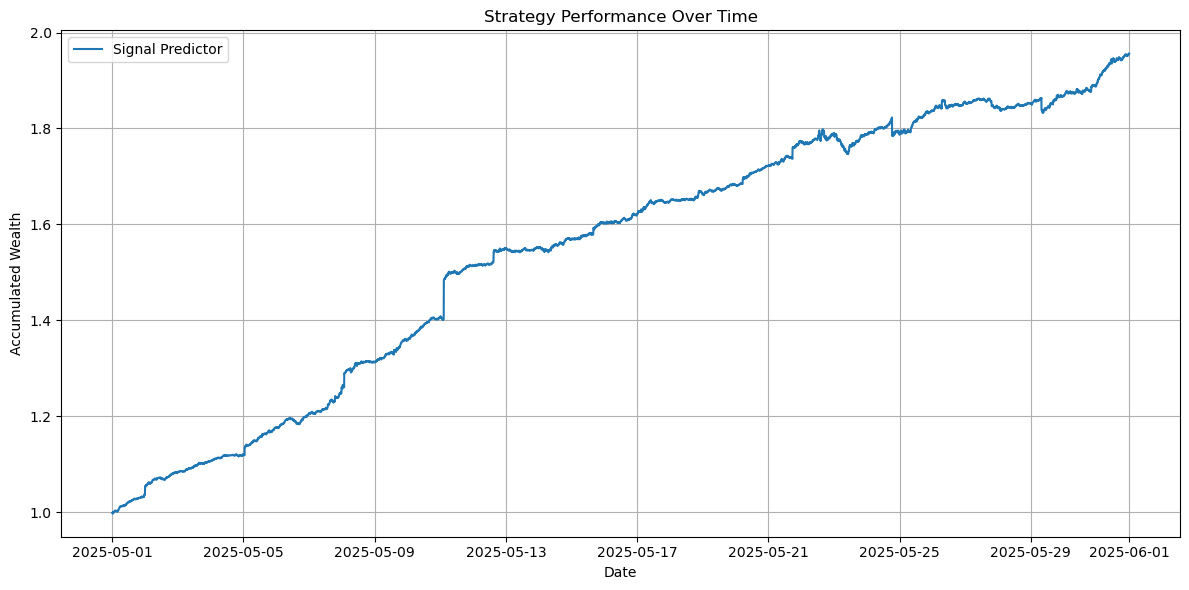

In [10]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns_signal_predictor,
        # 'XSMom': realized_returns_xsmom,
        # 'TSMom': realized_returns_tsmom,
        # 'BLSW': realized_returns_blsw,
    }, 
    start_time=config.data_config.train_set_last_date, 
    end_time=config.data_config.end
)

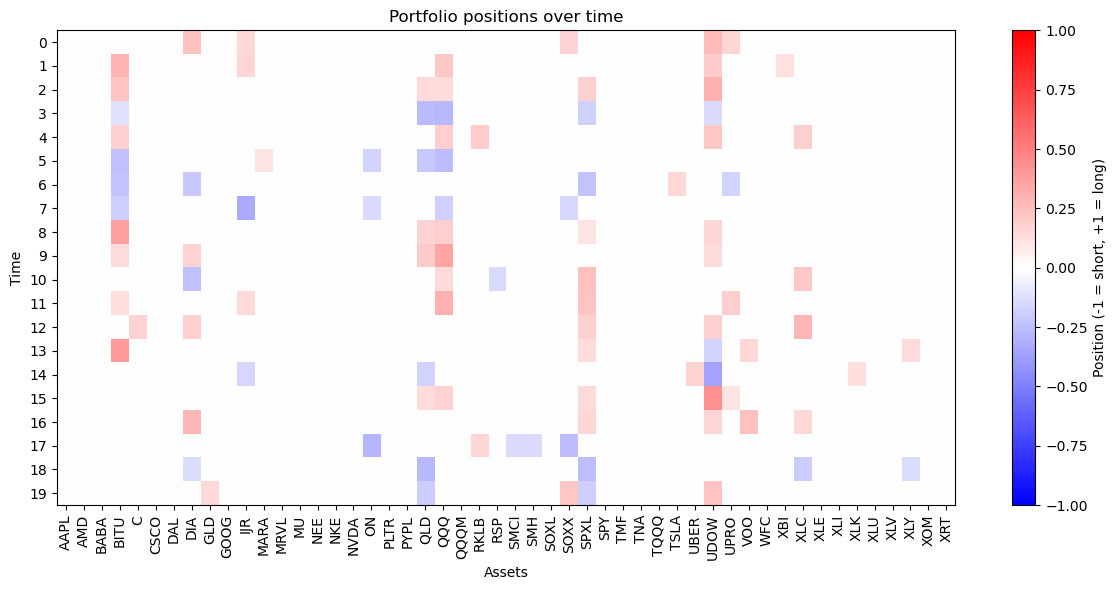

In [ ]:
plot_position_heatmap(actions_signal_predictor[:20], asset_names=config.data_config.symbol_or_symbols)

'MeanReturnPercentage'